# Case study 1: Distinguishing vertical and horizontal pleiotropy for SNP-protein associations

Mendelian randomization (MR), a technique to evaluate the causal role of modifiable exposures on a health outcome using a set of genetic instruments, tacitly assumes that a genetic variant (e.g. SNP) is only related to an outcome of interest through an exposure (i.e. the "exclusion restriction criterion"). 
Horizontal pleiotropy, where a SNP is associated with multiple phenotypes independently of the exposure of interest, potentially violates this assumption delivering misleading conclusions. 
In contrast, vertical pleiotropy, where a SNP is associated with multiple phenotypes on the same biological pathway, does not violate this assumption. 

Here, we use external evidence on biological pathways and protein-protein interactions to assess the pleiotropic profile for a genetic variant based on the genes (and proteins) with which that variant is associated. 
In a graph representation, we will show that:
- We have evidence of potential **vertical** pleiotropy when the proteins associated with a variant belong to one connected group,
- In contrast, if the proteins associated with a single variant are isolated from each other, this suggests evidence of **horizontal** pleiotropy.

This case study goes as follows:

- For a list of genes that we wish to assess their pleiotropic profiles (against a variant of interests), we retrieve from EpiGraphDB their mapped protein products.
- Then respecively from the evidence on shared pathway network and protein-protein interaction network, we can extract the proteins groups formed in these networks as connected communities to assess the pleiotropic profiles of the genes.

In [1]:
from itertools import permutations
from typing import List

import matplotlib.pyplot as plt
import networkx as nx
import requests
import pandas as pd

plt.rcParams["figure.figsize"] = (12, 9)

In [2]:
# Default parameters
API_URL = "https://api.epigraphdb.org"

In [3]:
# Parameters
API_URL = "http://dev-api.epigraphdb.org"

In [4]:
print(API_URL)
requests.get(f"{API_URL}/ping").json()

http://dev-api.epigraphdb.org


True

## Parameters

In this example we will look at the variant **rs12720356**, a SNP located in chromosome 19 that has been associated with Crohn’s disease and psoriasis.

We need two paramters for this case study:
- First, the list of genes associated with our eQTL of interest (rs12720356) that can be retrieved from GTEx portal (https://www.gtexportal.org/home/snp/rs12720356), or using their API (see Appendix below).
- Second, we need to specify the number of mediator proteins between a pair of proteins. Zero means a direct link, and higher values represent indirect links with N nodes in the middle.


In [5]:
SNP = "rs12720356"

GENE_LIST = [
    "ZGLP1",
    "FDX1L",
    "MRPL4",
    "ICAM5",
    "TYK2",
    "GRAP2",
    "KRI1",
    "TMED1",
    "ICAM1",
]

PPI_N_INTERMEDIATE_PROTEINS = 1

## Mapping genes to proteins

The first step of the analysis is to map each of these genes to their protein product, recovering one protein for each gene in our database.


In [6]:
def get_gene_protein(gene_list):

    # get gene-protein
    endpoint = "/mappings/gene-to-protein"
    url = f"{API_URL}{endpoint}"
    payload = {"gene_name_list": gene_list}
    r = requests.post(url, json=payload)
    r.raise_for_status()
    protein_df = pd.json_normalize(r.json()["results"])
    if len(protein_df) > 0:
        res_df = protein_df[["gene.name", "protein.uniprot_id"]].rename(
            columns={
                "gene.name": "protein_name",
                "protein.uniprot_id": "uniprot_id",
            }
        )
    else:
        return pd.DataFrame(columns=["protein_name", "uniprot_id"])

    return res_df


gene_protein_df = get_gene_protein(gene_list=GENE_LIST)
gene_protein_df

,protein_name,uniprot_id
0,ZGLP1,P0C6A0
1,FDX1L,Q6P4F2
2,MRPL4,Q9BYD3
3,ICAM5,Q9UMF0
4,TYK2,P29597
5,GRAP2,O75791
6,KRI1,Q8N9T8
7,TMED1,Q13445
8,ICAM1,P05362


## Identifying the involvement in the same biological pathways

Once we have the list of protein identifiers, for each protein we retrieve the pathways they are involved in, either as a single entity or as part of a complex.


In [7]:
def get_protein_pathway(gene_protein_df):
    endpoint = "/protein/in-pathway"
    url = f"{API_URL}{endpoint}"
    payload = {
        "uniprot_id_list": gene_protein_df["uniprot_id"].to_list(),
    }
    r = requests.post(url, json=payload)
    r.raise_for_status()
    df = pd.json_normalize(r.json()["results"])

    if len(df) > 0:
        res_df = gene_protein_df[["uniprot_id"]].merge(
            df, left_on="uniprot_id", right_on="uniprot_id", how="left"
        )
    else:
        res_df = (
            gene_protein_df[["uniprot_id"]]
            .assign(pathway_count=None)
            .assign(pathway_reactome_id=None)
        )
    res_df = res_df.assign(
        pathway_count=lambda df: df["pathway_count"]
        .apply(lambda x: 0 if pd.isna(x) else x)
        .astype(int)
    ).assign(
        pathway_reactome_id=lambda df: df["pathway_reactome_id"].apply(
            lambda x: [] if not isinstance(x, list) else x
        )
    )

    return res_df


pathway_df = get_protein_pathway(gene_protein_df=gene_protein_df)
pathway_df

,uniprot_id,pathway_count,pathway_reactome_id
0,P0C6A0,0,[]
1,Q6P4F2,15,"[R-HSA-8957322, R-HSA-5668914, R-HSA-5579029, ..."
2,Q9BYD3,6,"[R-HSA-72766, R-HSA-5419276, R-HSA-5389840, R-..."
3,Q9UMF0,5,"[R-HSA-216083, R-HSA-198933, R-HSA-168256, R-H..."
4,P29597,28,"[R-HSA-9679506, R-HSA-9679191, R-HSA-913531, R..."
5,O75791,15,"[R-HSA-9006934, R-HSA-389356, R-HSA-388841, R-..."
6,Q8N9T8,0,[]
7,Q13445,0,[]
8,P05362,11,"[R-HSA-913531, R-HSA-877300, R-HSA-6785807, R-..."


Now, for each pair of proteins we match the pathways they have in common.

In [8]:
def get_shared_pathway(pathway_df):

    # For the protein-pathway data
    # Get protein-protein permutations where they share pathways
    def per_permutation(pathway_df, permutation):
        df = pathway_df[pathway_df["uniprot_id"].isin(permutation)]
        shared_pathway = set(df["pathway_reactome_id"].iloc[0]).intersection(
            set(df["pathway_reactome_id"].iloc[1])
        )
        return shared_pathway

    pairwise_permutations = permutations(pathway_df["uniprot_id"], 2)

    shared_pathway_df = (
        pd.DataFrame(
            [
                {
                    "protein": permutation[0],
                    "assoc_protein": permutation[1],
                    "combination": sorted(permutation),
                    "shared_pathway": per_permutation(pathway_df, permutation),
                }
                for permutation in pairwise_permutations
            ]
        )
        .assign(count=lambda df: df["shared_pathway"].apply(lambda x: len(x)))
        .assign(connected=lambda df: df["count"].apply(lambda x: x > 0))
    )
    return shared_pathway_df


shared_pathway_df = get_shared_pathway(pathway_df)
print("Num. shared_pathway pairs: ", len(shared_pathway_df.query("count > 0")))
shared_pathway_df.sort_values(by="count", ascending=False)

Num. shared_pathway pairs:  14


,protein,assoc_protein,combination,shared_pathway,count,connected
39,P29597,P05362,"[P05362, P29597]","{R-HSA-913531, R-HSA-6783783, R-HSA-449147, R-...",6,True
68,P05362,P29597,"[P05362, P29597]","{R-HSA-913531, R-HSA-6783783, R-HSA-449147, R-...",6,True
31,Q9UMF0,P05362,"[P05362, Q9UMF0]","{R-HSA-1280218, R-HSA-216083, R-HSA-198933, R-...",5,True
67,P05362,Q9UMF0,"[P05362, Q9UMF0]","{R-HSA-1280218, R-HSA-216083, R-HSA-198933, R-...",5,True
36,P29597,O75791,"[O75791, P29597]","{R-HSA-168256, R-HSA-162582}",2,True
...,...,...,...,...,...,...
30,Q9UMF0,Q13445,"[Q13445, Q9UMF0]",{},0,False
32,P29597,P0C6A0,"[P0C6A0, P29597]",{},0,False
34,P29597,Q9BYD3,"[P29597, Q9BYD3]",{},0,False
1,P0C6A0,Q9BYD3,"[P0C6A0, Q9BYD3]",{},0,False


We can further query EpiGraphDB regarding the pathway information using `GET /meta/nodes/Pathway/search`.

In [9]:
def get_pathway_info(reactome_id):
    """Get additional info from Pathway name"""
    endpoint = "/meta/nodes/Pathway/search"
    url = f"{API_URL}{endpoint}"
    params = {"id": reactome_id}
    r = requests.get(url, params=params)
    r.raise_for_status()
    keep_columns = ["node.name", "node.id", "node.url"]
    df = pd.json_normalize(r.json()["results"])[keep_columns]
    return df


pathway = set()

for elem in shared_pathway_df[shared_pathway_df["connected"]][
    "shared_pathway"
].tolist():
    pathway = pathway.union(elem)

pathway_info = pd.concat(
    [get_pathway_info(reactome_id) for reactome_id in pathway]
).reset_index(drop=True)
pathway_info

,node.name,node.id,node.url
0,Interferon Signaling,R-HSA-913531,https://reactome.org/PathwayBrowser/#/R-HSA-91...
1,Immunoregulatory interactions between a Lympho...,R-HSA-198933,https://reactome.org/PathwayBrowser/#/R-HSA-19...
2,Interleukin-10 signaling,R-HSA-6783783,https://reactome.org/PathwayBrowser/#/R-HSA-67...
3,Signaling by Interleukins,R-HSA-449147,https://reactome.org/PathwayBrowser/#/R-HSA-44...
4,Adaptive Immune System,R-HSA-1280218,https://reactome.org/PathwayBrowser/#/R-HSA-12...
5,Integrin cell surface interactions,R-HSA-216083,https://reactome.org/PathwayBrowser/#/R-HSA-21...
6,Signal Transduction,R-HSA-162582,https://reactome.org/PathwayBrowser/#/R-HSA-16...
7,Cytokine Signaling in Immune system,R-HSA-1280215,https://reactome.org/PathwayBrowser/#/R-HSA-12...
8,Interleukin-4 and Interleukin-13 signaling,R-HSA-6785807,https://reactome.org/PathwayBrowser/#/R-HSA-67...
9,Disease,R-HSA-1643685,https://reactome.org/PathwayBrowser/#/R-HSA-16...


In order to extract protein groups from the shared pathways,
the last step for this query is to convert the shared pathway data into a graph where

- Proteins are represented as nodes.
- And shared pathways are represented as edges.
- Then the protein groups (via shared pathways) are the connected communities in the graph.

We then count the number of nodes in each connected community and plot the graph.

In [10]:
# Convert protein data to a graph
# then extract protein groups from the graph


def protein_df_to_graph(df):
    df_connected = (
        df.query("`connected`")
        # Convert combination to a string singleton
        .assign(
            combination=lambda df: df["combination"].apply(lambda x: str(x))
        ).drop_duplicates(subset=["combination"])
    )

    df_isolated = df.query("not `connected`")[["protein"]].drop_duplicates()

    # Create the graph of the connected nodes, then
    # add isolated nodes
    graph = nx.from_pandas_edgelist(df_connected, "protein", "assoc_protein")
    for node in df_isolated["protein"].to_list():
        nx.add_path(graph, [node])

    return graph


def graph_to_protein_groups(graph):
    components = nx.connected_components(graph)
    res = [{"group_members": item, "group_size": len(item)} for item in components]
    return res


def draw_graph(graph):
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(
        G=graph,
        pos=pos,
        node_size=2800,
        alpha=0.8,
        with_labels=True,
        node_color="#e53935",
        font_color="k",
    )

In [11]:
pathway_protein_graph = protein_df_to_graph(shared_pathway_df)
pathway_protein_groups = graph_to_protein_groups(pathway_protein_graph)
pathway_protein_groups

[{'group_members': {'O75791', 'P05362', 'P29597', 'Q6P4F2', 'Q9UMF0'},
  'group_size': 5},
 {'group_members': {'P0C6A0'}, 'group_size': 1},
 {'group_members': {'Q9BYD3'}, 'group_size': 1},
 {'group_members': {'Q8N9T8'}, 'group_size': 1},
 {'group_members': {'Q13445'}, 'group_size': 1}]

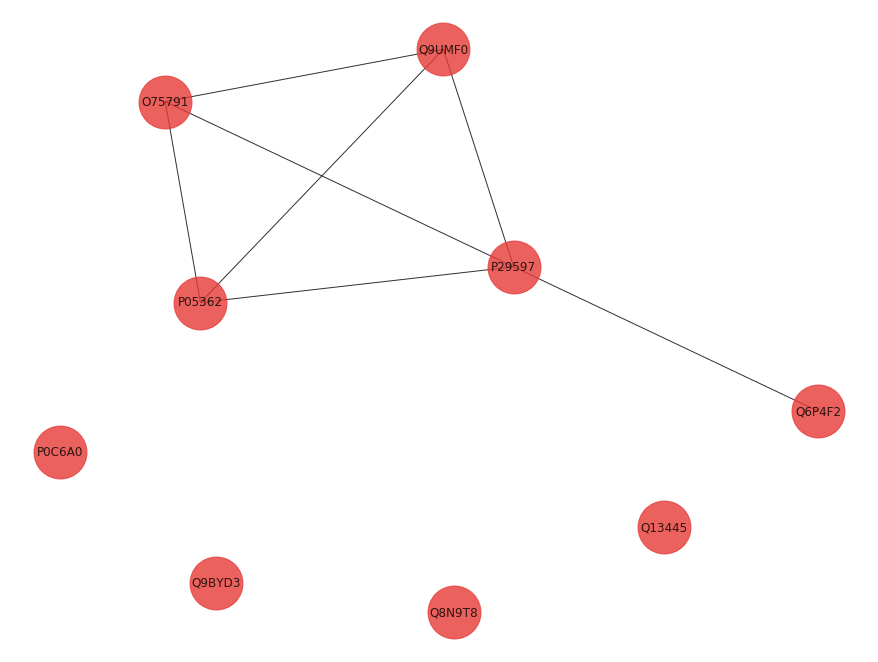

In [12]:
draw_graph(pathway_protein_graph)

## Retrieving shared protein-protein interactions

We can complement the information given by pathway ontologies with data of interactions between proteins. For each pair of proteins, we retrieve shared protein-protein interactions, either a direct interaction or an interaction where there's one mediator protein in the middle (see paramaters section).

In [13]:
def get_ppi(gene_protein_df, n_intermediate_proteins: int = 0):
    endpoint = "/protein/ppi/pairwise"
    url = f"{API_URL}{endpoint}"
    payload = {
        "uniprot_id_list": gene_protein_df["uniprot_id"].to_list(),
        "n_intermediate_proteins": n_intermediate_proteins,
    }
    r = requests.post(url, json=payload)
    r.raise_for_status()
    df = pd.json_normalize(r.json()["results"])

    if len(df) > 0:
        res_df = (
            gene_protein_df[["uniprot_id"]]
            .rename(columns={"uniprot_id": "protein"})
            .merge(df, left_on="protein", right_on="protein", how="left")
        )
    else:
        res_df = (
            gene_protein_df[["uniprot_id"]]
            .rename(columns={"uniprot_id": "protein"})
            .assign(assoc_protein=None, path_size=None)
        )
    return res_df


ppi_df = get_ppi(gene_protein_df, n_intermediate_proteins=PPI_N_INTERMEDIATE_PROTEINS)
ppi_count = ppi_df.groupby(["protein", "assoc_protein"]).count()
ppi_count.rename(columns={"path_size": "count"})
ppi_count

path_size
protein assoc_protein           
O75791  O75791               152
        P05362                64
        P29597                20
P05362  O75791                64
        P05362               314
        P29597                48
        Q9UMF0                 8
P0C6A0  P0C6A0                 2
P29597  O75791                20
        P05362                48
        P29597               218
Q13445  Q13445                 8
Q6P4F2  Q6P4F2                36
Q8N9T8  Q8N9T8               268
        Q9BYD3                16
Q9BYD3  Q8N9T8                16
        Q9BYD3               370
Q9UMF0  P05362                 8
        Q9UMF0                 6

Like in the query for pathway data, we convert and analyse these results as a graph.

In [14]:
def get_shared_ppi(ppi_df):
    def per_row(ppi_df, protein, assoc_protein):
        df = ppi_df.query(
            f"`protein` == '{protein}' & `assoc_protein` == '{assoc_protein}'"
        )
        return True if len(df) > 0 else False

    pairwise_permutations = permutations(ppi_df["protein"].drop_duplicates(), 2)

    shared_ppi_df = pd.DataFrame(
        [
            {
                "protein": permutation[0],
                "assoc_protein": permutation[1],
                "combination": sorted(permutation),
                "shared_ppi": per_row(ppi_df, *permutation),
            }
            for permutation in pairwise_permutations
        ]
    ).assign(connected=lambda df: df["shared_ppi"])
    return shared_ppi_df


shared_ppi_df = get_shared_ppi(ppi_df)
print("Num. shared_ppi pairs: ", len(shared_ppi_df.query("shared_ppi")))
shared_ppi_df

Num. shared_ppi pairs:  10


,protein,assoc_protein,combination,shared_ppi,connected
0,P0C6A0,Q6P4F2,"[P0C6A0, Q6P4F2]",False,False
1,P0C6A0,Q9BYD3,"[P0C6A0, Q9BYD3]",False,False
2,P0C6A0,Q9UMF0,"[P0C6A0, Q9UMF0]",False,False
3,P0C6A0,P29597,"[P0C6A0, P29597]",False,False
4,P0C6A0,O75791,"[O75791, P0C6A0]",False,False
...,...,...,...,...,...
67,P05362,Q9UMF0,"[P05362, Q9UMF0]",True,True
68,P05362,P29597,"[P05362, P29597]",True,True
69,P05362,O75791,"[O75791, P05362]",True,True
70,P05362,Q8N9T8,"[P05362, Q8N9T8]",False,False


In [15]:
ppi_protein_graph = protein_df_to_graph(shared_ppi_df)
ppi_protein_groups = graph_to_protein_groups(ppi_protein_graph)
ppi_protein_groups

[{'group_members': {'Q8N9T8', 'Q9BYD3'}, 'group_size': 2},
 {'group_members': {'O75791', 'P05362', 'P29597', 'Q9UMF0'}, 'group_size': 4},
 {'group_members': {'P0C6A0'}, 'group_size': 1},
 {'group_members': {'Q6P4F2'}, 'group_size': 1},
 {'group_members': {'Q13445'}, 'group_size': 1}]

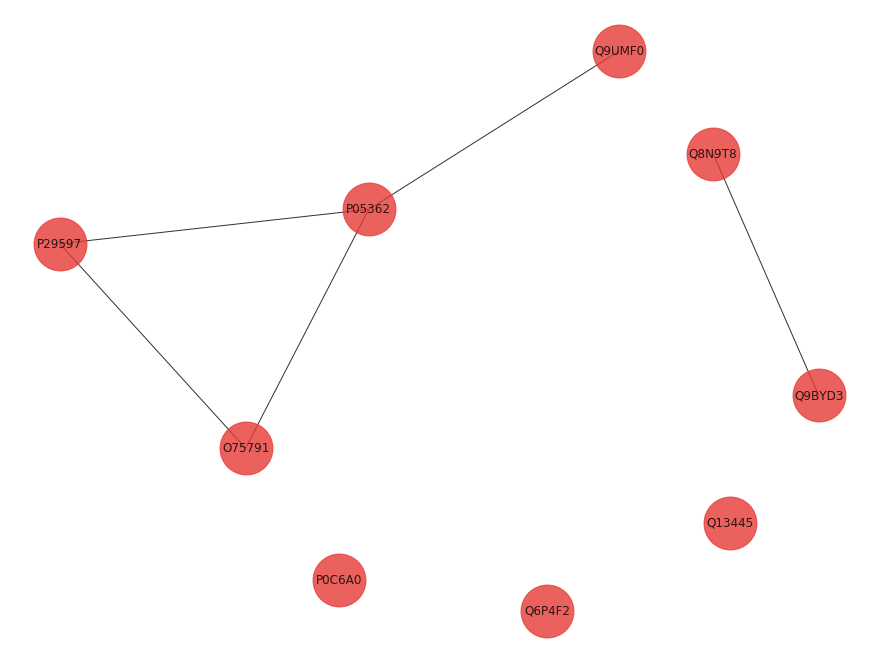

In [16]:
draw_graph(ppi_protein_graph)


## Appendix: Querying GTEx for single tissue eQTLs

Below is the query to retrieve and parse the single tissue eQTL data for the SNP rs12720356.

In [17]:
def get_gtex_eqtl(snp):

    # get single tissue eQTL
    url = "https://gtexportal.org/rest/v1/association/singleTissueEqtl"
    payload = {"format": "json", "snpId": snp, "datasetId": "gtex_v8"}
    r = requests.get(url, params=payload)
    r.raise_for_status()
    eqtl_df = pd.json_normalize(r.json()["singleTissueEqtl"])
    if len(eqtl_df) > 0:
        res_df = (
            eqtl_df[["gencodeId", "pValue", "tissueSiteDetailId"]]
            .rename(
                columns={
                    "gencodeId": "ensembl_id",
                    "pValue": "pval",
                    "tissueSiteDetailId": "tissue",
                }
            )
            .assign(
                ensembl_id=lambda df: df["ensembl_id"].apply(lambda x: x.split(".")[0])
            )
        )

    else:
        return pd.DataFrame(columns=["ensembl_id", "pval", "tissue"])

    return res_df


eqtl_df = (
    get_gtex_eqtl(snp=SNP)
    # For each gene, select the lowest pval, then collect all tissues
    .groupby("ensembl_id")
    .apply(
        lambda group_df: pd.DataFrame(
            {
                "pval": group_df["pval"].min(),
                "tissue": [group_df["tissue"].tolist()],
            }
        ).rename_axis("level")
    )
    .reset_index(level="level", drop=True)
)

eqtl_df

,pval,tissue
ensembl_id,,
ENSG00000090339,1.035110e-04,[Whole_Blood]
ENSG00000099203,4.804360e-05,[Whole_Blood]
ENSG00000105364,6.797370e-09,"[Skin_Not_Sun_Exposed_Suprapubic, Artery_Tibia..."
ENSG00000105376,7.561840e-07,[Whole_Blood]
ENSG00000105397,3.017820e-06,"[Whole_Blood, Adrenal_Gland]"
ENSG00000129347,9.941250e-06,[Skin_Sun_Exposed_Lower_leg]
ENSG00000161847,5.448880e-06,[Whole_Blood]
ENSG00000220201,1.128130e-15,"[Thyroid, Skin_Not_Sun_Exposed_Suprapubic, Pro..."
ENSG00000267673,2.929330e-11,"[Thyroid, Artery_Tibial, Nerve_Tibial, Brain_C..."


In [18]:
def get_epigraphdb_gene_name(ensembl_id):

    endpoint = "/meta/nodes/Gene/search"
    url = f"{API_URL}{endpoint}"
    params = {"id": ensembl_id, "full_data": False}
    r = requests.get(url, params=params)
    r.raise_for_status()
    res = r.json()
    if not res["metadata"]["empty_results"]:
        return res["results"][0]["name"]


gene_name_df = pd.DataFrame.from_records(
    [
        {
            "ensembl_id": ensembl_id,
            "name": get_epigraphdb_gene_name(ensembl_id),
        }
        for ensembl_id in list(eqtl_df.index)
    ]
)
gene_name_df

,ensembl_id,name
0,ENSG00000090339,ICAM1
1,ENSG00000099203,TMED1
2,ENSG00000105364,MRPL4
3,ENSG00000105376,ICAM5
4,ENSG00000105397,TYK2
5,ENSG00000129347,KRI1
6,ENSG00000161847,RAVER1
7,ENSG00000220201,ZGLP1
8,ENSG00000267673,FDX1L
